<a href="https://colab.research.google.com/github/elliothebert/quantitative-analysis/blob/main/2_CNN_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install split-folders
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import splitfolders
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
input_folder = "/content/drive/MyDrive/horse-or-human"

output_folder = '/content/drive/MyDrive/horse:human'

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 260 files [01:28,  3.36 files/s]

KeyboardInterrupt: ignored

In [4]:
print(len(os.listdir('/content/drive/MyDrive/horse:human/test/horses')))
print(len(os.listdir('/content/drive/MyDrive/horse:human/train/horses')))
print(len(os.listdir('/content/drive/MyDrive/horse:human/val/horses')))

50
350
100


In [5]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

--2022-09-27 16:20:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  84.2MB/s    in 1.0s    

2022-09-27 16:20:39 (84.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []   

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


                                                                                                  
 activation_12 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 activation_14 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 activation_17 (Activation)     (None, 16, 16, 96)   0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 mixed1 (Concatenate)           (None, 16, 16, 288)  0           ['activation_12[0][0]',          
          

In [8]:
train_dir = '/content/drive/MyDrive/horse:human/train'
validation_dir = '/content/drive/MyDrive/horse:human/val'
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 5,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 5,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 718 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [9]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 10,
            validation_steps = 20,
            verbose = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
20/20 [==============================] - 55s 2s/step - loss: 0.5780 - acc: 0.8300 - val_loss: 0.1425 - val_acc: 0.9600
Epoch 2/10
20/20 [==============================] - 21s 1s/step - loss: 0.0881 - acc: 0.9700 - val_loss: 0.0379 - val_acc: 0.9900
Epoch 3/10
20/20 [==============================] - 16s 804ms/step - loss: 0.0597 - acc: 0.9694 - val_loss: 1.9213e-04 - val_acc: 1.0000
Epoch 4/10
20/20 [==============================] - 8s 421ms/step - loss: 0.2225 - acc: 0.9300 - val_loss: 0.0186 - val_acc: 0.9900
Epoch 5/10
20/20 [==============================] - 5s 245ms/step - loss: 0.0539 - acc: 0.9900 - val_loss: 0.0128 - val_acc: 0.9900
Epoch 6/10
20/20 [==============================] - 6s 333ms/step - loss: 0.0305 - acc: 0.9900 - val_loss: 0.0583 - val_acc: 0.9800
Epoch 7/10
20/20 [==============================] - 4s 196ms/step - loss: 0.1073 - acc: 0.9500 - val_loss: 0.0087 - val_acc: 0.9900
Epoch 8/10
20/20 [==============================] - 3s 145ms/step - loss: 0

<Figure size 432x288 with 0 Axes>

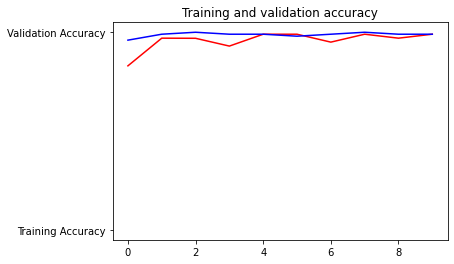

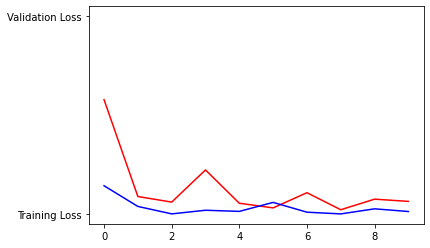

<Figure size 432x288 with 0 Axes>

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()
